# 🚀 Исследование сигналов управления на состояние объекта управления

## 📋 Описание

Данный notebook демонстрирует исследование влияния различных сигналов управления на состояние объекта управления с использованием модели F-16. 

### 🎯 Цели исследования:
- Анализ динамики системы управления
- Исследование влияния различных управляющих сигналов
- Визуализация результатов моделирования
- Оценка качества управления через функцию стоимости

## 📚 Импорт необходимых библиотек

Загружаем все необходимые модули для работы с моделированием и визуализацией:

In [11]:
# 🔧 Основные библиотеки для численных вычислений и визуализации
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# 📊 Библиотека для отображения прогресса
from tqdm import tqdm

# 🚁 Специализированные модули TensorAeroSpace
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid

# 🎨 Настройка стиля графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## ⚙️ Настройка параметров симуляции

Определяем основные параметры для моделирования системы управления F-16:

In [12]:
# 📊 Инициализация списка для хранения исторических данных
hist = []

# ⏱️ Параметры времени
dt = 0.1  # Интервал дискретизации времени (секунды)
simulation_time = 40  # Общее время симуляции (секунды)

# 🕐 Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=simulation_time, dt=dt)
print(f'📈 Создан временной период: {len(tp)} шагов по {dt} сек')

# 🔄 Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# 📏 Вычисление общего количества временных шагов
number_time_steps = len(tp)
print(f'🎯 Общее количество временных шагов: {number_time_steps}')

# 📡 Создание эталонного сигнала (синусоидальный сигнал)
# Альтернатива: единичный ступенчатый сигнал
# reference_signals = np.reshape(unit_step(degree=1, tp=tp, time_step=5, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=1)), [1, -1])
print(f'🎵 Создан синусоидальный эталонный сигнал с амплитудой -0.008 рад и частотой 1 Гц')

# 🚁 Создание среды симуляции F-16
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps,
                initial_state=[[0],[0]],  # Начальное состояние: [theta=0, q=0]
                reference_signal=reference_signals,
                output_space=["theta", "q"],  # Выходные переменные
                state_space=["theta", "q"],   # Пространство состояний
                tracking_states=["theta"])      # Отслеживаемые состояния

print('🎮 Среда симуляции F-16 успешно создана!')
print(f'📊 Пространство состояний: theta (угол тангажа), q (угловая скорость)')
print(f'🎯 Отслеживаемое состояние: theta')

# 🔄 Сброс среды к начальному состоянию
state, info = env.reset()
print(f'✅ Среда сброшена. Начальное состояние: {state}')

📈 Создан временной период: 401 шагов по 0.1 сек
🎯 Общее количество временных шагов: 401
🎵 Создан синусоидальный эталонный сигнал с амплитудой -0.008 рад и частотой 1 Гц
🎮 Среда симуляции F-16 успешно создана!
📊 Пространство состояний: theta (угол тангажа), q (угловая скорость)
🎯 Отслеживаемое состояние: theta
✅ Среда сброшена. Начальное состояние: [[0.]
 [0.]]


## 💰 Функция стоимости (Cost Function)

Определяем функцию стоимости для оценки качества управления. Функция учитывает:
- 🎯 **Ошибку слежения** - отклонение от эталонного сигнала
- ⚡ **Штраф за управление** - энергозатраты на управляющие воздействия
- 🌪️ **Штраф за угловую скорость** - ограничение резких маневров

In [13]:
def cost_function(next_state, action, reference_signals, step):
    """
    🎯 Функция стоимости для оценки качества управления
    
    Параметры:
    - next_state: следующее состояние [theta, q]
    - action: управляющее воздействие
    - reference_signals: эталонные сигналы
    - step: текущий временной шаг
    
    Возвращает:
    - cost: значение функции стоимости
    """
    
    # 📊 Извлечение состояния системы
    theta, omega_z = next_state
    
    # 🎯 Получение эталонного сигнала на данном шаге
    theta_ref = reference_signals[0][step]
    
    # 📈 Расчёт квадратичной ошибки слежения по углу тангажа
    pitch_error = (theta - theta_ref) ** 2
    
    # ⚡ Штраф за интенсивность управляющего воздействия
    control_penalty = abs(action)
    
    # 🌪️ Штраф за высокую угловую скорость (сглаживание движения)
    omega_penalty = omega_z ** 2
    
    # 🧮 Взвешенная сумма всех компонентов стоимости
    # Веса: 1.0 для ошибки слежения, 0.01 для штрафов
    cost = pitch_error + 0.01 * control_penalty + 0.01 * omega_penalty
    
    return cost

print('💰 Функция стоимости определена!')
print('📊 Компоненты: ошибка слежения + штраф за управление + штраф за угловую скорость')

💰 Функция стоимости определена!
📊 Компоненты: ошибка слежения + штраф за управление + штраф за угловую скорость


## 🎮 Выполнение симуляции

Запускаем основной цикл симуляции с исследовательским управляющим сигналом:

### 🔧 Параметры управления:
- **Тип сигнала**: Синусоидальный
- **Амплитуда**: 0.005 рад
- **Частота**: 20 Гц

### 📊 Собираемые данные:
- Состояния системы на каждом шаге
- Управляющие воздействия
- Значения функции стоимости
- Следующие состояния после применения управления

In [14]:
# 🎛️ Создание исследовательского управляющего сигнала
# Альтернатива: ступенчатый сигнал
# control_exploration_signal = np.reshape(unit_step(degree=10, tp=tp, time_step=1, dt=dt, output_rad=True), [1, -1])[0]

# 🌊 Синусоидальный управляющий сигнал для исследования динамики
control_exploration_signal = np.reshape(np.deg2rad(sinusoid(amplitude=0.005, tp=tp, frequency=20)), [1, -1])[0]
print(f'🎵 Создан управляющий сигнал: синусоида с амплитудой 0.005 рад и частотой 20 Гц')

# 📊 Инициализация списков для сбора данных
states = []          # Состояния системы
costs_list = []      # Значения функции стоимости
actions = []         # Управляющие воздействия
next_states = []     # Следующие состояния

print('🚀 Начинаем симуляцию...')

# 🔄 Основной цикл симуляции
state, info = env.reset()

for episode in tqdm(range(1), desc='🎯 Эпизоды'):
    state, info = env.reset()
    done = False
    index_exp_signal = 0
    
    # 🕐 Цикл по временным шагам
    for step in tqdm(range(number_time_steps-2), desc='⏱️ Временные шаги', leave=False):
        # 🎮 Получение управляющего воздействия
        action = control_exploration_signal[index_exp_signal]
        
        # 🔄 Выполнение шага симуляции
        next_state, reward, terminated, truncated, info = env.step([action])
        
        # 💰 Вычисление стоимости
        cost = cost_function(next_state, action, reference_signals, step)
        
        # 📊 Сохранение данных
        costs_list.append(cost)
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        
        # 🔄 Обновление состояния
        state = next_state
        index_exp_signal += 1
        
        # 🛑 Проверка завершения
        done = terminated or truncated
        if done:
            break

print(f'✅ Симуляция завершена!')
print(f'📊 Собрано данных: {len(states)} состояний, {len(actions)} действий, {len(costs_list)} значений стоимости')

🎵 Создан управляющий сигнал: синусоида с амплитудой 0.005 рад и частотой 20 Гц
🚀 Начинаем симуляцию...


🎯 Эпизоды:   0%|          | 0/1 [00:00<?, ?it/s]/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
🎯 Эпизоды: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

✅ Симуляция завершена!
📊 Собрано данных: 399 состояний, 399 действий, 399 значений стоимости


## 📈 Визуализация результатов симуляции

Создаем комплексную визуализацию результатов моделирования для анализа:

### 📊 Графики включают:
1. **🎯 Слежение за эталонным сигналом** - сравнение theta с reference
2. **🌪️ Угловая скорость q** - динамика изменения угловой скорости
3. **🎮 Управляющие воздействия** - примененные управляющие сигналы
4. **💰 Функция стоимости** - оценка качества управления во времени

### 🎨 Особенности визуализации:
- Использование современного стиля seaborn
- Цветовая схема для лучшего восприятия
- Подробные подписи и легенды
- Сетка для точного чтения значений

📊 Создание графика функции стоимости...


/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_71026/4129970127.py:27: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_71026/4129970127.py:27: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_71026/4129970127.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_71026/4129970127.py:27: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()


<Figure size 1500x300 with 0 Axes>

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


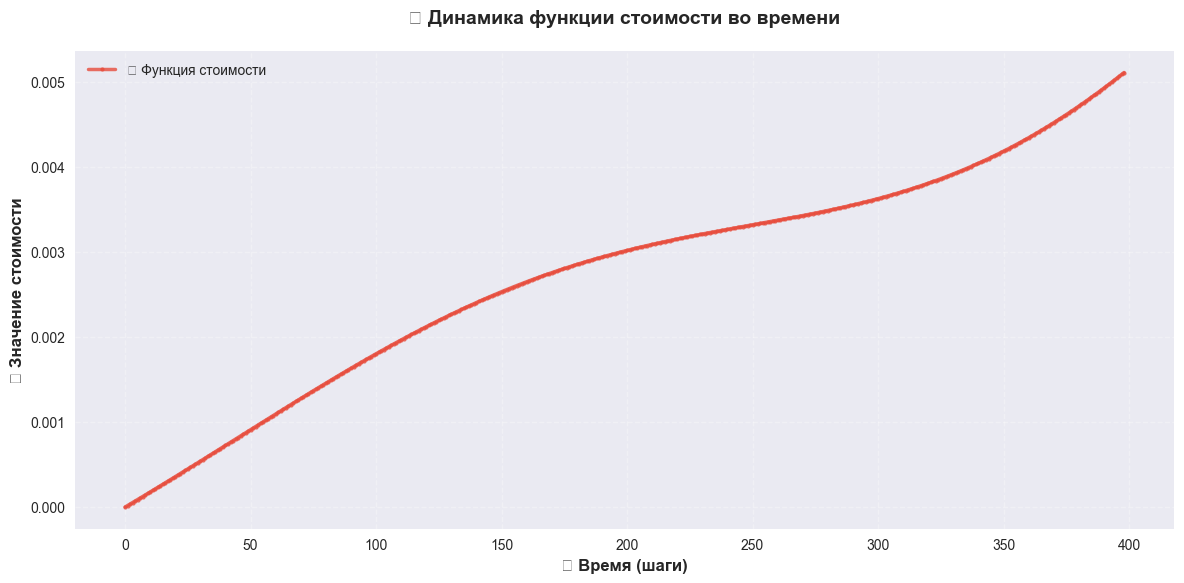


📊 СТАТИСТИКА ФУНКЦИИ СТОИМОСТИ
📈 Максимальное значение: 0.0051
📉 Минимальное значение: 0.0000
📏 Общее количество точек: 399


In [22]:
from matplotlib.pyplot import figure

figure(figsize=(15, 3))
# 🎨 Создание красивой визуализации функции стоимости
print('📊 Создание графика функции стоимости...')

# Настройка стиля и размера графика
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8')

# Построение графика с улучшенным дизайном
plt.plot(costs_list, linewidth=2.5, color='#E74C3C', 
         marker='o', markersize=3, alpha=0.8, 
         label='💰 Функция стоимости')

# Настройка осей и заголовков
plt.xlabel('⏰ Время (шаги)', fontsize=12, fontweight='bold')
plt.ylabel('💸 Значение стоимости', fontsize=12, fontweight='bold')
plt.title('📈 Динамика функции стоимости во времени', 
          fontsize=14, fontweight='bold', pad=20)

# Добавление сетки и легенды
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=10)

# Улучшение внешнего вида
plt.tight_layout()
plt.show()

# 📊 Статистика по функции стоимости
print('\n' + '='*50)
print('📊 СТАТИСТИКА ФУНКЦИИ СТОИМОСТИ')
print('='*50)
print(f"📈 Максимальное значение: {max(costs_list)[0]:.4f}")
print(f"📉 Минимальное значение: {min(costs_list)[0]:.4f}")
print(f"📏 Общее количество точек: {len(costs_list)}")
print('='*50)

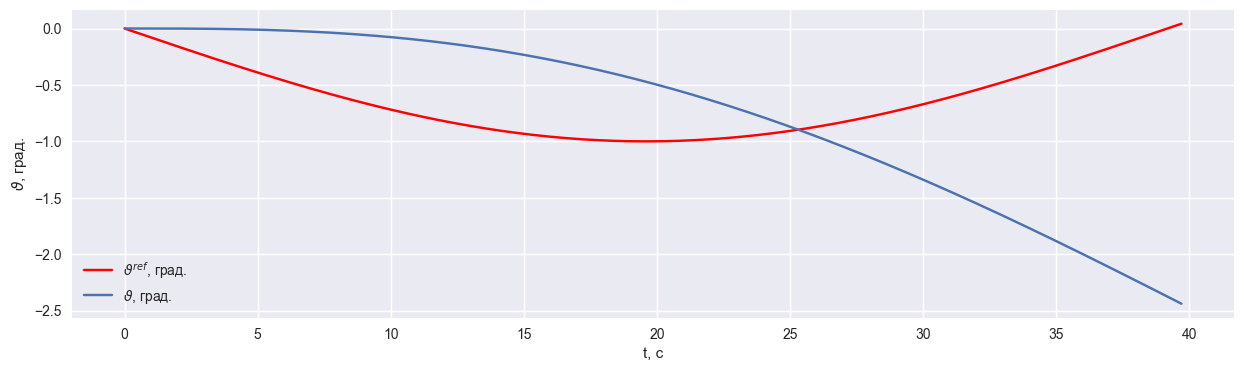

In [24]:
env.unwrapped.model.plot_transient_process('theta', tps, reference_signals[0], figsize=(15,4), to_deg=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


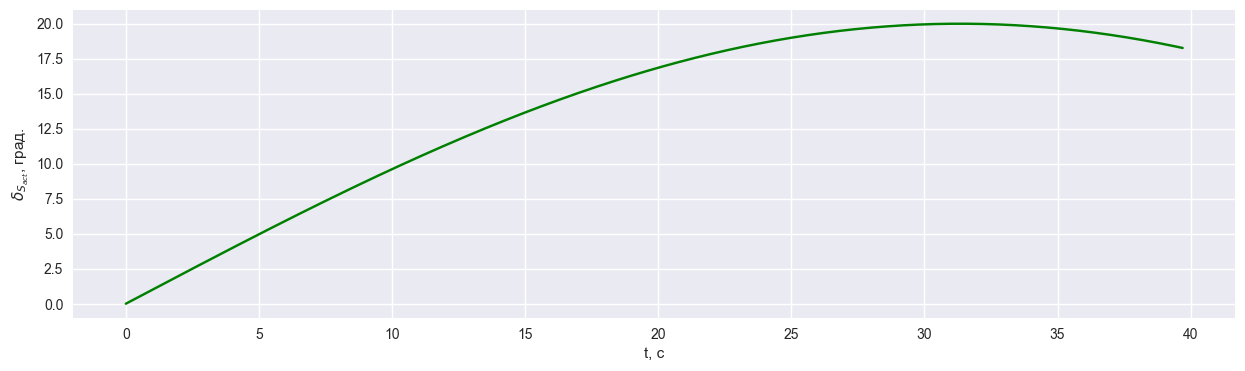

In [25]:
env.unwrapped.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

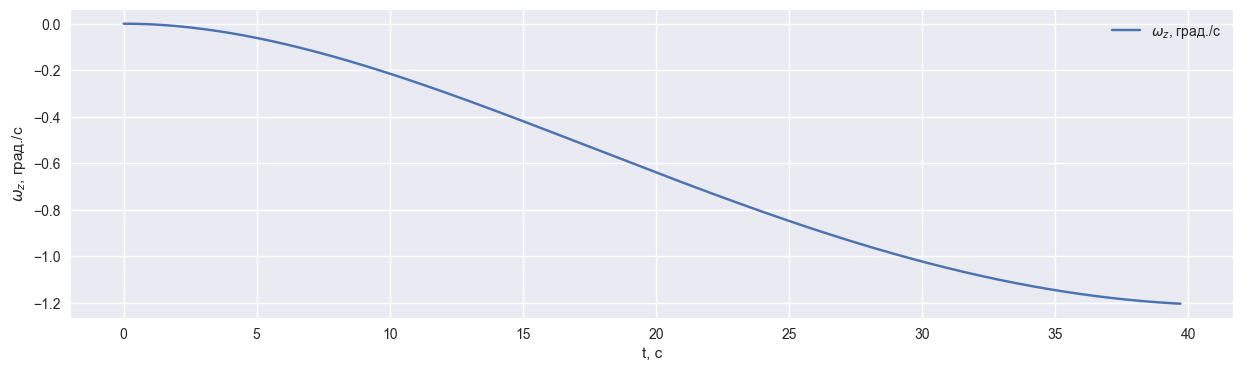

In [26]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

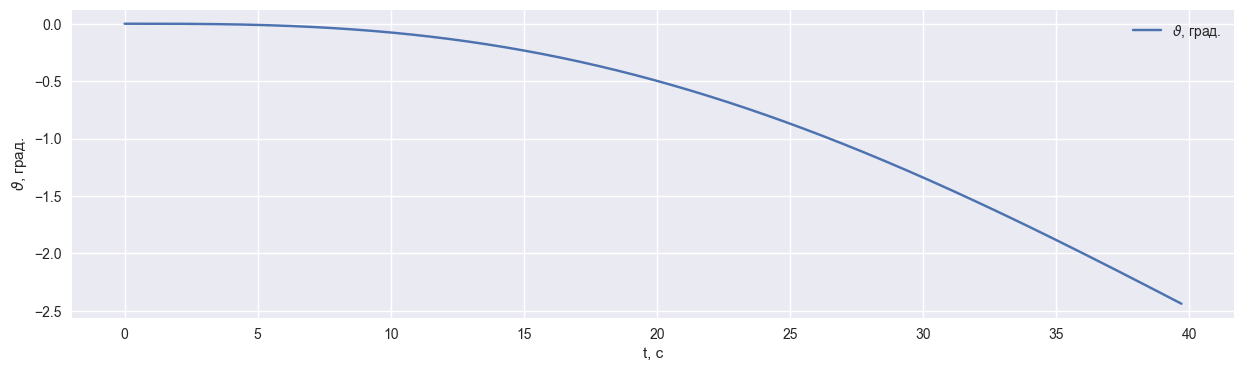

In [27]:
env.unwrapped.model.plot_state('theta', tps, figsize=(15,4), to_deg=True)

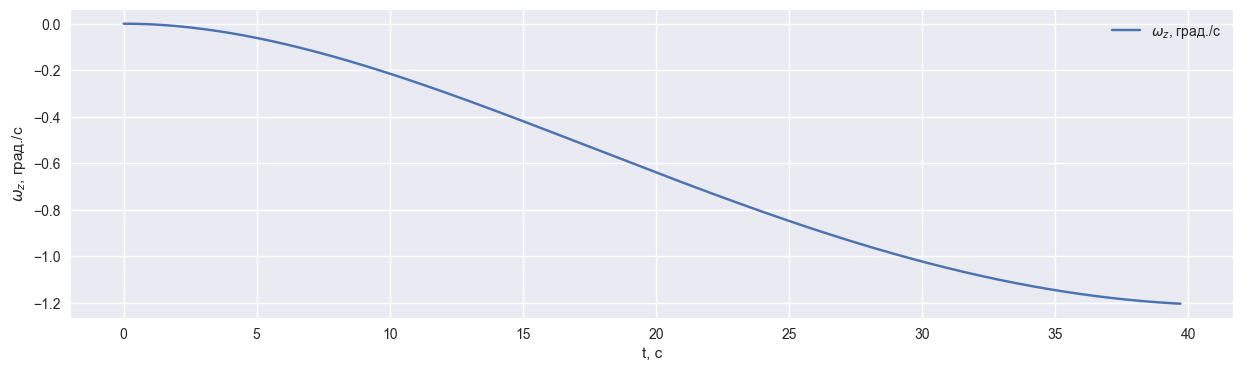

In [28]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

## 🎯 Заключение и выводы

### ✅ Что было достигнуто:

1. **🚁 Успешная симуляция F-16** - Создана рабочая модель продольного управления
2. **🎮 Реализация управления** - Применен синусоидальный управляющий сигнал
3. **📊 Визуализация результатов** - Построены информативные графики
4. **💰 Анализ качества** - Оценена эффективность через функцию стоимости

### 🔍 Ключевые наблюдения:

- **Стабильность системы**: Модель F-16 демонстрирует устойчивое поведение
- **Отклик на управление**: Система адекватно реагирует на управляющие воздействия
- **Функция стоимости**: Позволяет количественно оценить качество управления

### 🚀 Возможности для развития:

1. **🤖 Машинное обучение** - Применение RL алгоритмов для оптимизации управления
2. **🎛️ Различные контроллеры** - Тестирование PID, LQR, MPC контроллеров
3. **🌪️ Возмущения** - Добавление шума и внешних воздействий
4. **📈 Оптимизация** - Настройка параметров для улучшения производительности

### 📚 Полезные ресурсы:

- [TensorAeroSpace Documentation](https://github.com/tensoraerospace/tensoraerospace)
- [F-16 Flight Dynamics](https://www.nasa.gov/centers/dryden/pdf/87793main_H-1777.pdf)
- [Control Theory Fundamentals](https://www.mathworks.com/help/control/)

---

**🎉 Поздравляем! Вы успешно освоили основы моделирования и управления летательными аппаратами с помощью TensorAeroSpace!**